# Feature Engineering Student Score Data

In this assessment, you'll continue working with the [U.S. Exam Score dataset](https://www.kaggle.com/spscientist/students-performance-in-exams) from Kaggle. This dataset consists of information about some student backgrounds and the students' exam results in math, reading, and writing. To learn more about the data and the column descriptions, you can view the Kaggle link above. You can access the data from the Thinkful database.

We will start by importing relevant libraries.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sqlalchemy import create_engine, text
import warnings
import string

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM studentsperformance""")
    student_df = pd.read_sql_query(query, conn)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

Then we will look at summary statistics through `describe`.

In [29]:
student_df.describe(include='all')

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


It is clear that the database has both continuous and categorical variables. We will also look at the `head` to get more familiar with the data.

In [30]:
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Data Cleaning

In [31]:
student_df.loc[student_df['math score'] == 0]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
59,female,group C,some high school,free/reduced,none,0,17,10


Math score has a 0 in its set at index 59. This will hinder the Box-Cox transformation, because all values must be positive. Let's transform this value to something small which is greater than zero.

In [32]:
student_df['math score'] = student_df['math score'].apply(lambda x: 1e-5 if x == 0 else x)
student_df.iloc[59]

gender                                   female
race/ethnicity                          group C
parental level of education    some high school
lunch                              free/reduced
test preparation course                    none
math score                              0.00001
reading score                                17
writing score                                10
Name: 59, dtype: object


## Functions

In [33]:
# Plot the distribution of scores
def scores_distplot(series1,series2,series3):
    plt.figure(figsize=(15,5))
    plt.suptitle("Exam scores distribution")

    ax1 = plt.subplot(1,3,1)
    sns.distplot(series1)
    ax1.set_xlabel("Math score")

    ax2 = plt.subplot(1,3,2)
    sns.distplot(series2)
    ax2.set_xlabel("Reading score")

    ax3 = plt.subplot(1,3,3)
    sns.distplot(series3)
    ax3.set_xlabel("Writing score")

    plt.show()

In [34]:
# Check normality
def is_normal(series1,series2,series3):
    norm_stats1 = normaltest(series1)
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats1[0], norm_stats1[1]))
    norm_stats2 = normaltest(series2)
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats2[0], norm_stats2[1]))
    norm_stats3 = normaltest(series3)
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats3[0], norm_stats3[1]))

In [46]:
# Compare bar plots
def barplot_comparison(df,y_col,x_list,**kwargs):
    nostats = kwargs.get('nostats',False)
    plt.figure(figsize=(15,5))
    plt.suptitle("Comparing {} by {}".format(string.capwords(', '.join(x_list)),
                                             string.capwords(y_col)),
                 fontsize=16)
    num_subplots = len(x_list)
    for subplot, score in enumerate(x_list,1):
        ax = plt.subplot(1,num_subplots,subplot)
        g=sns.barplot(x=score,
                    y=y_col,
                    data=df)
    plt.tight_layout()
    plt.show()
    all_cols = x_list.insert(0,y_col)
    grouped_values = df[x_list].groupby(y_col)
    if (nostats != True):
        print(grouped_values.describe())

In [65]:
# Return mean and count of Dataframe
def get_df_mean_and_count(df,name):
 display(df.groupby(name).mean())
 display(df.groupby(name).count())

#### Q1: Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

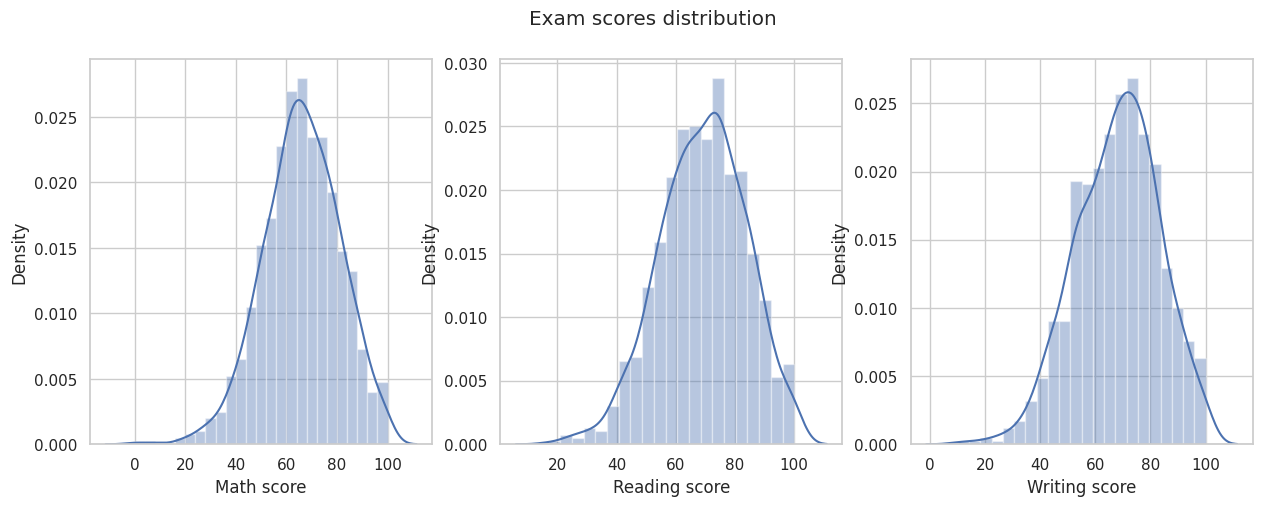

In [35]:
scores_distplot(student_df['math score'],
                student_df['reading score'],
                student_df['writing score'])

By visual inspection, the exam scores look normally distributed. We can use the
Jarque-Bera test for normality, but [the docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html) recommend at least 2000 records. As we only have 1000 records, we will use the [normality test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html).

In [36]:
is_normal(student_df['math score'],student_df['reading score'],student_df['writing score'])

Normality test statistics is 15.408954518435541 and p value is 0.000450804290095075
Normality test statistics is 11.11741279628622 and p value is 0.003853758403576582
Normality test statistics is 13.606450837263859 and p value is 0.0011101885439899974


These low p-values (below 0.05) suggest that the data is not normally distributed. Let's apply a box-con transformation.

In [37]:
math_boxcox,_ = boxcox(student_df['math score'])
reading_boxcox,_ = boxcox(student_df['reading score'])
english_boxcox,_ = boxcox(student_df['writing score'])

Now let's check for normality.

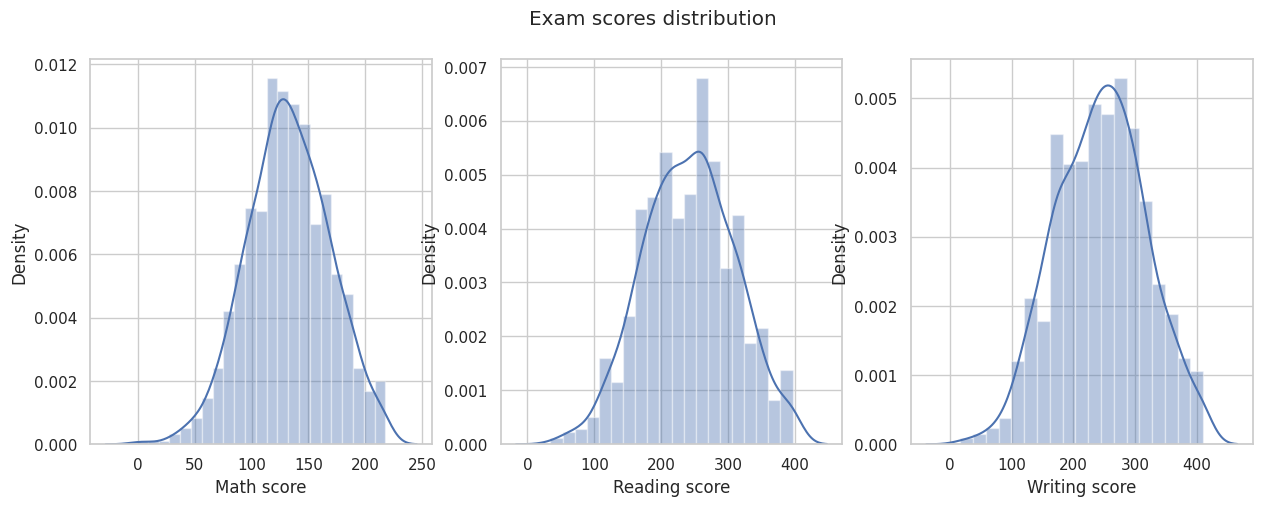

In [38]:
scores_distplot(math_boxcox,
                reading_boxcox,
                english_boxcox)

In [39]:
is_normal(math_boxcox,reading_boxcox,english_boxcox)

Normality test statistics is 1.6539196786239272 and p value is 0.43737696337304965
Normality test statistics is 5.282274606965809 and p value is 0.07128015626992971
Normality test statistics is 6.267311355052559 and p value is 0.04355827085003712


This fixed the math score and helped with the reading and writing scores. However, the reading and writing scores are stuill not normally distributed.

#### Q2: Say you want to use a single variable for the exam scores as your target. For this purpose, create a new variable by taking an average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

We can use a weighted average of the exam scores and check normality.

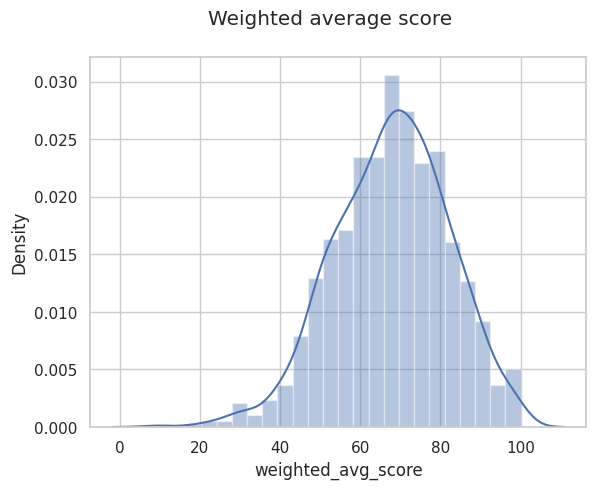

In [42]:
student_df['weighted_avg_score'] = (student_df['math score']
                                   + student_df['reading score']
                                   + student_df['writing score'])/3

plt.suptitle("Weighted average score")
sns.distplot(student_df['weighted_avg_score'])
plt.show()

In [43]:
jb_stats = jarque_bera(exam_score)
norm_stats = normaltest(exam_score)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 15.453386351162669 and p value is 0.00044089968696950935
Normality test statistics is 15.186719834456976 and p value is 0.0005037855294683642


Once again, the test show that the weighted average isn't normally distributed. Let's apply a box-con transformation and see if that helps.

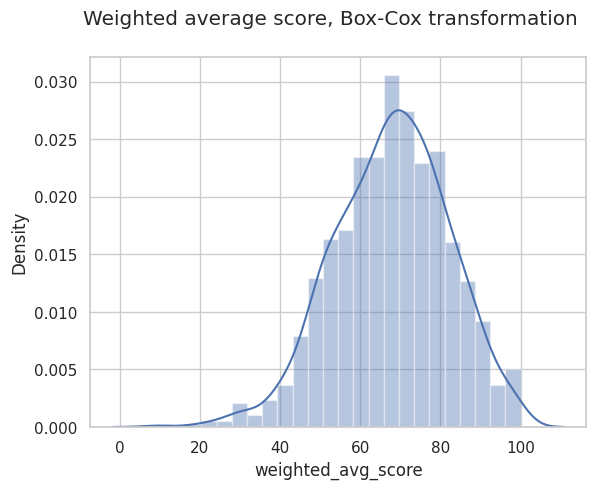

In [44]:
boxcox_weighted,_ = boxcox(student_df['weighted_avg_score'])

plt.suptitle("Weighted average score, Box-Cox transformation")
sns.distplot(student_df['weighted_avg_score'])
plt.show()

In [45]:
jb_stats = jarque_bera(boxcox_weighted)
norm_stats = normaltest(boxcox_weighted)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 2.4353989904756554 and p value is 0.29591012715495385
Normality test statistics is 2.779857626773395 and p value is 0.24909303609017588


This time the box-con transformation makes the weighted average normally distributed as confirmed by both tests.

#### Q3: Which variables seem related to the target variable (the newly created variable from the previous question)? If your goal is to explain the determinants of success in exams, which variables in your dataset might be useful?

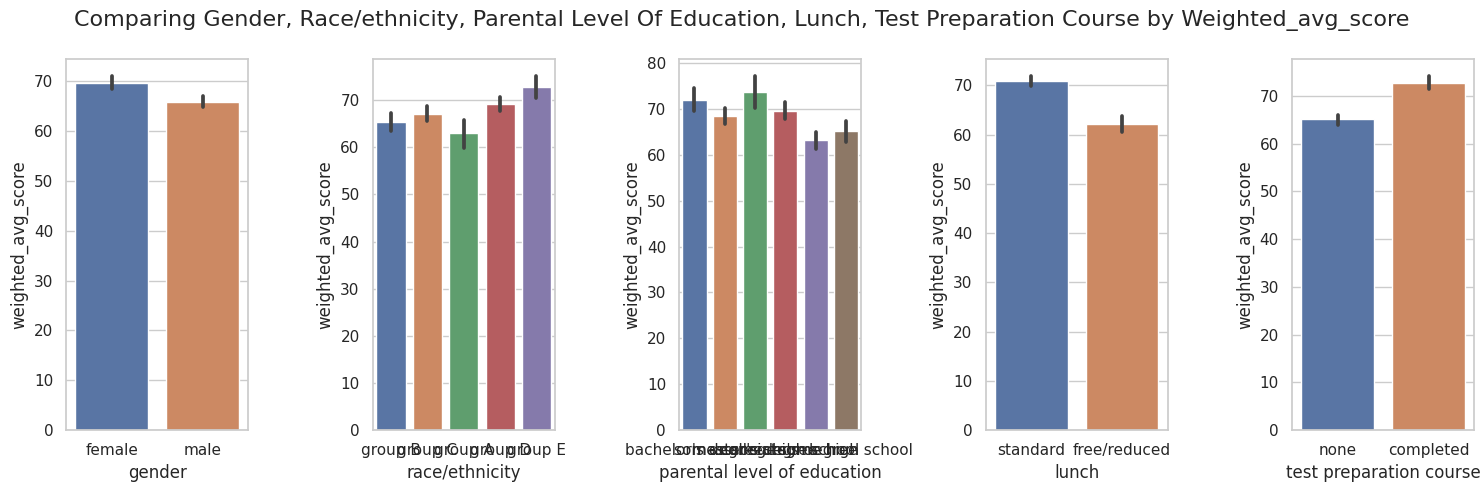

In [47]:
barplot_comparison(student_df,
                   'weighted_avg_score',
                   ['gender','race/ethnicity','parental level of education','lunch','test preparation course'],
                  nostats=True)

The highest weighted average scores are associated with:

* __Master's Degree__ of the parental level of education category (73.598870, 59 students)
* __Group E__ of the race/ethnicity category (72.752381, 140 students)
* __Completed a test preparation course__ (72.669460, 358 students)
* __Bachelor's Degree__ of the parental level of education category (71.923729, 118 students)
* __Standard lunch__ (70.837209, 645 students)
* __Women__ (69.569498, 518 students)

In terms of importance to the target variable, one could rank the categorial variable in the following manner:
1. Students who __completed a test preparation course__ represent the third-highest test score among these five, and the third-largest group, with 358 students.

2. Students who eat a __standard lunch__ are the largest group by far with 645 students, though their average test score only ranks fifth of the top five.

3. __Parental level of education__ is probably the next most important factor, having two of the top five average scores (first and fourth), and a total of 177 students.

4. __Women__--gender seems to be significant, having the second-largest group (518 students) and holding the sixth-highest average test score.

5. __Race/ethnicity, group E__ has the second highest test score, but this group only has 140 students.

In [68]:
# Return mean and count of test preparation course
get_df_mean_and_count(student_df,'test preparation course')

,math score,reading score,writing score,weighted_avg_score
test preparation course,,,,
completed,69.695531,73.893855,74.418994,72.669460
none,64.077882,66.534268,64.504673,65.038941


,gender,race/ethnicity,parental level of education,lunch,math score,reading score,writing score,weighted_avg_score
test preparation course,,,,,,,,
completed,358,358,358,358,358,358,358,358
none,642,642,642,642,642,642,642,642


In [66]:
# Return mean and count of lunch
get_df_mean_and_count(student_df,'lunch')

,math score,reading score,writing score,weighted_avg_score
lunch,,,,
free/reduced,58.921127,64.653521,63.022535,62.199061
standard,70.034109,71.654264,70.823256,70.837209


,gender,race/ethnicity,parental level of education,test preparation course,math score,reading score,writing score,weighted_avg_score
lunch,,,,,,,,
free/reduced,355,355,355,355,355,355,355,355
standard,645,645,645,645,645,645,645,645


In [69]:
# Return mean and count of parental level of education
get_df_mean_and_count(student_df,'parental level of education')

,math score,reading score,writing score,weighted_avg_score
parental level of education,,,,
associate's degree,67.882883,70.927928,69.896396,69.569069
bachelor's degree,69.389831,73.000000,73.381356,71.923729
high school,62.137755,64.704082,62.448980,63.096939
master's degree,69.745763,75.372881,75.677966,73.598870
some college,67.128319,69.460177,68.840708,68.476401
some high school,63.497207,66.938547,64.888268,65.108007


,gender,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,weighted_avg_score
parental level of education,,,,,,,,
associate's degree,222,222,222,222,222,222,222,222
bachelor's degree,118,118,118,118,118,118,118,118
high school,196,196,196,196,196,196,196,196
master's degree,59,59,59,59,59,59,59,59
some college,226,226,226,226,226,226,226,226
some high school,179,179,179,179,179,179,179,179


In [70]:
# Return mean and count of gender
get_df_mean_and_count(student_df,'gender')

,math score,reading score,writing score,weighted_avg_score
gender,,,,
female,63.633205,72.608108,72.467181,69.569498
male,68.728216,65.473029,63.311203,65.837483


,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,weighted_avg_score
gender,,,,,,,,
female,518,518,518,518,518,518,518,518
male,482,482,482,482,482,482,482,482


In [71]:
# Return mean and count of race/ethnicity
get_df_mean_and_count(student_df,'race/ethnicity')

,math score,reading score,writing score,weighted_avg_score
race/ethnicity,,,,
group A,61.629213,64.674157,62.674157,62.992509
group B,63.452632,67.352632,65.600000,65.468421
group C,64.463950,69.103448,67.827586,67.131661
group D,67.362595,70.030534,70.145038,69.179389
group E,73.821429,73.028571,71.407143,72.752381


,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,weighted_avg_score
race/ethnicity,,,,,,,,
group A,89,89,89,89,89,89,89,89
group B,190,190,190,190,190,190,190,190
group C,319,319,319,319,319,319,319,319
group D,262,262,262,262,262,262,262,262
group E,140,140,140,140,140,140,140,140
